<a href="https://colab.research.google.com/github/RaflyPD2684/Kelompok-4-KAV/blob/main/Kelompok_4_KAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integration Multi-Modal Features untuk General Sound Analysis

Pertimbangkan bagaimana statistical spectral features (spectral centroid, skewness, kurtosis) dan MPEG-7 descriptors dapat diintegrasikan dengan domain-specific features (speech, music) untuk membangun sistem analisis audio yang komprehensif. Bagaimana feature selection dan dimensionality reduction dapat dioptimalkan untuk berbagai domain aplikasi? Diskusikan potential synergies dan conflicts yang mungkin timbul ketika menggabungkan fitur-fitur yang dirancang untuk aspek perseptual audio yang berbeda.

In [1]:
#@title Install dependensi
!pip -q install librosa==0.10.2.post1 soundfile==0.12.1 numpy scipy pandas scikit-learn

import os, sys, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import librosa
import soundfile as sf
from scipy.stats import skew, kurtosis

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

In [2]:
#@title (Opsional) Mount Google Drive
USE_DRIVE = False  #@param {type:"boolean"}
DATA_DIR = "/content/data"  #@param {type:"string"}  # isi folder audio kamu di sini; boleh berisi subfolder per-label

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    # contoh: DATA_DIR = "/content/drive/MyDrive/audio"
os.makedirs(DATA_DIR, exist_ok=True)
print("DATA_DIR =", DATA_DIR)

DATA_DIR = /content/data


In [3]:
#@title Buat contoh dataset kecil (hanya untuk demo)
MAKE_DEMO = True  #@param {type:"boolean"}
if MAKE_DEMO:
    os.makedirs(f"{DATA_DIR}/speech", exist_ok=True)
    os.makedirs(f"{DATA_DIR}/music", exist_ok=True)
    os.makedirs(f"{DATA_DIR}/env", exist_ok=True)

    # Ambil contoh dari librosa (perlu internet)
    try:
        y_trumpet, sr = librosa.load(librosa.ex('trumpet'), sr=22050, mono=True)
        sf.write(f"{DATA_DIR}/music/trumpet_demo.wav", y_trumpet, sr)
    except Exception as e:
        print("Gagal ambil contoh trumpet:", e)

    # Sinyal sintetik 'speech-like' (formant-ish) & 'env-like' (noise/impulse)
    sr = 22050
    t = np.linspace(0, 2.5, int(2.5*sr), endpoint=False)
    speech_like = 0.6*np.sin(2*np.pi*220*t) + 0.3*np.sin(2*np.pi*660*t)
    env_like = 0.05*np.random.randn(t.size)
    sf.write(f"{DATA_DIR}/speech/speech_sine.wav", speech_like, sr)
    sf.write(f"{DATA_DIR}/env/noise_env.wav", env_like, sr)

    print("Contoh data dibuat.")

Contoh data dibuat.


In [4]:
#@title Ekstraktor fitur

def spectral_statistics(y, sr, n_fft=2048, hop_length=512):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    mag = S + 1e-12
    mag_norm = mag / np.maximum(mag.sum(axis=0, keepdims=True), 1e-12)

    centroid = (freqs[:, None] * mag_norm).sum(axis=0)
    spread = np.sqrt(((freqs[:, None] - centroid[None, :])**2 * mag_norm).sum(axis=0))

    z = (freqs[:, None] - centroid[None, :]) / np.maximum(spread[None, :], 1e-12)
    skewness = (np.power(z, 3) * mag_norm).sum(axis=0)
    kurt = (np.power(z, 4) * mag_norm).sum(axis=0) - 3.0

    flatness = librosa.feature.spectral_flatness(S=mag)[0]
    rolloff = librosa.feature.spectral_rolloff(S=mag, sr=sr, roll_percent=0.95)[0]
    flux = np.sqrt(np.sum(np.diff(mag, axis=1)**2, axis=0))

    return {
        "centroid": centroid,
        "spread": spread,
        "skewness": skewness,
        "kurtosis": kurt,
        "flatness": flatness,
        "rolloff": rolloff,
        "flux": flux
    }

def temporal_descriptors(y, sr, hop_length=512):
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    times = librosa.times_like(oenv, sr=sr, hop_length=hop_length)
    temporal_centroid = float(np.sum(times * oenv) / np.maximum(np.sum(oenv), 1e-8)) if oenv.size else 0.0
    lat = float(times[np.argmax(oenv)]) if oenv.size else 0.0  # Log-attack-time sederhana
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    return {
        "temporal_centroid": temporal_centroid,
        "log_attack_time": lat,
        "zcr_mean": float(np.mean(zcr)),
        "zcr_std": float(np.std(zcr))
    }

def speech_like(y, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    d1 = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)
    f0 = librosa.yin(y, fmin=50, fmax=min(600, sr//2), sr=sr)

    voiced = ~np.isnan(f0)
    voiced_ratio = float(np.mean(voiced)) if f0.size else 0.0

    return {
        "mfcc_mean": np.mean(mfcc, axis=1).tolist(),
        "mfcc_std": np.std(mfcc, axis=1).tolist(),
        "dmfcc_mean": np.mean(d1, axis=1).tolist(),
        "ddmfcc_mean": np.mean(d2, axis=1).tolist(),
        "f0_mean": float(np.nanmean(f0)),
        "f0_std": float(np.nanstd(f0)),
        "voiced_ratio": voiced_ratio
    }

def music_like(y, sr):
    y_h, y_p = librosa.effects.hpss(y)
    chroma = librosa.feature.chroma_cqt(y=y_h, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y_p, sr=sr)
    onset_env = librosa.onset.onset_strength(y=y_p, sr=sr)
    onset_density = float(np.mean(onset_env))
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    return {
        "chroma_mean": np.mean(chroma, axis=1).tolist(),
        "chroma_std": np.std(chroma, axis=1).tolist(),
        "tempo": float(tempo),
        "onset_density": onset_density,
        "spec_contrast_mean": np.mean(spectral_contrast, axis=1).tolist(),
        "spec_contrast_std": np.std(spectral_contrast, axis=1).tolist(),
    }

def summarize_vector(x):
    return {
        "mean": float(np.mean(x)),
        "std": float(np.std(x)),
        "p25": float(np.percentile(x, 25)),
        "p50": float(np.percentile(x, 50)),
        "p75": float(np.percentile(x, 75)),
    }

In [5]:
#@title Build metadata (file, label)
def scan_data_dir(data_dir):
    rows = []
    for root, dirs, files in os.walk(data_dir):
        for fn in files:
            if fn.lower().endswith((".wav", ".flac", ".mp3", ".ogg")):
                path = os.path.join(root, fn)
                label = os.path.basename(os.path.dirname(path))
                rows.append({"file": path, "label": label})
    return pd.DataFrame(rows)

meta = scan_data_dir(DATA_DIR)
if meta.empty:
    raise SystemExit("Tidak menemukan audio di DATA_DIR. Isi dulu data atau aktifkan MAKE_DEMO.")
meta.sample(min(5, len(meta)))

,file,label
1,/content/data/env/noise_env.wav,env
2,/content/data/music/trumpet_demo.wav,music
0,/content/data/speech/speech_sine.wav,speech


In [6]:
#@title Ekstraksi fitur gabungan (statistik + MPEG7-like + speech + music)
def extract_one(path, sr_target=22050):
    y, sr = librosa.load(path, sr=sr_target, mono=True)
    # normalisasi loudness sederhana (opsional): scale ke RMS target
    rms = np.sqrt(np.mean(y**2) + 1e-12)
    if rms > 0:
        y = y / rms

    spec = spectral_statistics(y, sr)
    temp = temporal_descriptors(y, sr)
    sp = speech_like(y, sr)
    mu = music_like(y, sr)

    row = {"file": path}

    # ringkas statistik spektral
    for k, arr in spec.items():
        s = summarize_vector(arr)
        for stat_name, val in s.items():
            row[f"STAT_{k}_{stat_name}"] = val

    # temporal (skalar)
    for k, v in temp.items():
        row[f"MPEG7_{k}"] = v  # "MPEG7-like"

    # speech-like (mfcc/delta/f0/voiced)
    for i, v in enumerate(sp["mfcc_mean"]): row[f"SP_mfcc{i+1}_mean"] = float(v)
    for i, v in enumerate(sp["mfcc_std"]):  row[f"SP_mfcc{i+1}_std"]  = float(v)
    for i, v in enumerate(sp["dmfcc_mean"]): row[f"SP_dmfcc{i+1}_mean"] = float(v)
    for i, v in enumerate(sp["ddmfcc_mean"]): row[f"SP_ddmfcc{i+1}_mean"] = float(v)
    row["SP_f0_mean"] = sp["f0_mean"]; row["SP_f0_std"] = sp["f0_std"]; row["SP_voiced_ratio"] = sp["voiced_ratio"]

    # music-like (chroma/tempo/onset/contrast)
    for i, v in enumerate(mu["chroma_mean"]): row[f"MU_chroma{i}_mean"] = float(v)
    for i, v in enumerate(mu["chroma_std"]):  row[f"MU_chroma{i}_std"]  = float(v)
    row["MU_tempo"] = mu["tempo"]; row["MU_onset_density"] = mu["onset_density"]
    for i, v in enumerate(mu["spec_contrast_mean"]): row[f"MU_contrast{i}_mean"] = float(v)
    for i, v in enumerate(mu["spec_contrast_std"]):  row[f"MU_contrast{i}_std"]  = float(v)

    return row

rows = []
for i, r in meta.iterrows():
    try:
        rows.append(extract_one(r["file"]))
    except Exception as e:
        print("Skip:", r["file"], "| err:", e)

feat_df = pd.DataFrame(rows)
feat_df["label"] = meta["label"].values[:len(feat_df)]
print("shape:", feat_df.shape)
feat_df.head(3)

shape: (3, 136)


,file,STAT_centroid_mean,STAT_centroid_std,STAT_centroid_p25,STAT_centroid_p50,STAT_centroid_p75,STAT_spread_mean,STAT_spread_std,STAT_spread_p25,STAT_spread_p50,...,MU_contrast5_mean,MU_contrast6_mean,MU_contrast0_std,MU_contrast1_std,MU_contrast2_std,MU_contrast3_std,MU_contrast4_std,MU_contrast5_std,MU_contrast6_std,label
0,/content/data/speech/speech_sine.wav,370.865487,23.078838,366.891235,366.923497,366.950820,244.232221,100.185817,225.871671,226.576915,...,14.281516,14.023528,5.431453,3.259169,3.908094,3.651163,2.197612,2.991221,2.836598,speech
1,/content/data/env/noise_env.wav,5530.904427,77.097780,5477.925607,5530.051965,5581.194138,3182.384993,29.705366,3162.629833,3183.949270,...,13.713460,13.496634,2.794978,2.891030,2.524237,1.867753,1.418091,1.191261,0.921696,env
2,/content/data/music/trumpet_demo.wav,2589.114590,1543.511044,1483.625058,1822.492786,3981.836524,1808.906154,1014.853945,982.163836,1266.000425,...,25.952900,22.786418,5.198652,7.528820,8.698227,10.307315,10.341722,11.039896,7.952109,music


In [7]:
#@title Simpan fitur ke CSV
OUT_CSV = "features.csv"  #@param {type:"string"}
feat_df.to_csv(OUT_CSV, index=False)
print("saved:", OUT_CSV)

saved: features.csv


In [8]:
#@title Training baseline (aman untuk data kecil, auto-CV & auto-steps)
from collections import Counter
from sklearn.model_selection import StratifiedKFold, KFold, ShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np, pandas as pd

df = pd.read_csv(OUT_CSV)

# Pastikan hanya kolom numerik yang dipakai sebagai fitur
num_cols = df.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number]).columns
X = df[num_cols].values
y = df["label"].astype(str).values

n, p = X.shape
counts = Counter(y)
min_class = min(counts.values())

# ---- Kebijakan adaptif untuk data kecil ----
# 1) Matikan MI (SelectKBest) jika data terlalu sedikit (sering error di n<8)
use_mi = (n >= 8) and (min_class >= 2)
# 2) Pakai PCA hanya kalau layak (n dan p cukup)
use_pca = (n >= 6) and (p > 3)

steps = [("scaler", StandardScaler())]
if use_mi:
    # n_neighbors=1 biar nggak melebihi jumlah sampel per-fold
    steps.append(("kbest", SelectKBest(
        score_func=lambda X_, y_: mutual_info_classif(X_, y_, n_neighbors=1, random_state=42),
        k=min( max(1, p//2), 64 )
    )))
if use_pca:
    # komponen maksimum dibatasi oleh (min(n_train-1, p)), tapi kita set aman secara global
    steps.append(("pca", PCA(n_components=0.95, svd_solver="full")))
steps.append(("clf", LogisticRegression(max_iter=500, penalty="l2")))

pipe = Pipeline(steps)

# ---- Skema CV aman ----
if min_class >= 2 and n >= 4:
    n_splits = int(min(5, min_class, n))
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_name = f"StratifiedKFold({n_splits})"
elif n >= 3:
    n_splits = int(min(3, n))
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_name = f"KFold({n_splits})"
else:
    cv = ShuffleSplit(n_splits=3, test_size=0.5, random_state=42)
    cv_name = "ShuffleSplit(3, test_size=0.5)"

# Kalau ada fold gagal (mis. train berisi 1 kelas), jangan crash → jadikan NaN
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", error_score=np.nan)

print(f"n={n}, p={p}, classes={dict(counts)}")
print(f"CV={cv_name}, use_mi={use_mi}, use_pca={use_pca}")
print("Fold F1-macro:", np.round(scores, 4))
valid = scores[~np.isnan(scores)]
if valid.size:
    print("Mean ± Std (valid folds):", np.round(valid.mean(), 4), "±", np.round(valid.std(), 4))
else:
    print("Semua fold gagal karena data terlalu kecil/imbalanced.")
    print("Tambahkan sampel per kelas (≥2) atau pakai hold-out split sederhana.")

n=3, p=134, classes={'speech': 1, 'env': 1, 'music': 1}
CV=KFold(3), use_mi=False, use_pca=False
Fold F1-macro: [0. 0. 0.]
Mean ± Std (valid folds): 0.0 ± 0.0


In [9]:
#@title Ablation aman untuk data kecil (STAT, MPEG7, SP, MU)
from collections import Counter
from itertools import combinations
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold, ShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# pastikan df & OUT_CSV sudah ada dari langkah sebelumnya
df = pd.read_csv(OUT_CSV)

# definisi keluarga fitur
all_cols = df.columns.tolist()
FAMILIES = {
    "STAT": [c for c in all_cols if c.startswith("STAT_")],
    "MPEG7": [c for c in all_cols if c.startswith("MPEG7_")],
    "SP":   [c for c in all_cols if c.startswith("SP_")],
    "MU":   [c for c in all_cols if c.startswith("MU_")],
}

# target & fitur numerik
y = df["label"].astype(str).values

def choose_cv(y):
    counts = Counter(y); n = len(y); min_class = min(counts.values())
    if min_class >= 2 and n >= 4:
        n_splits = min(5, min_class, n)
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42), f"StratifiedKFold({n_splits})"
    elif n >= 3:
        n_splits = min(3, n)
        return KFold(n_splits=n_splits, shuffle=True, random_state=42), f"KFold({n_splits})"
    else:
        return ShuffleSplit(n_splits=3, test_size=0.5, random_state=42), "ShuffleSplit(3, 0.5)"

CV, CV_NAME = choose_cv(y)
print("CV used:", CV_NAME)

def eval_family(cols, name):
    # hanya pakai kolom numerik
    sub = df[cols].select_dtypes(include=[np.number])
    if sub.shape[1] == 0 or len(df) < 2:
        return name, np.nan  # tidak ada fitur / data terlalu kecil

    X = sub.values
    n, p = X.shape
    counts = Counter(y); min_class = min(counts.values())

    # aturan adaptif
    use_mi  = (n >= 8 and min_class >= 2 and p > 1)
    use_pca = (n >= 6 and p > 3)

    # classifier: KNN(1) untuk dataset mungil; LR untuk yang agak wajar
    clf = KNeighborsClassifier(n_neighbors=1) if (n < 8 or min_class < 2) else LogisticRegression(max_iter=300)

    steps = [("scaler", StandardScaler())]
    if use_mi:
        steps.append(("kbest", SelectKBest(
            score_func=lambda X_, y_: mutual_info_classif(X_, y_, n_neighbors=1, random_state=42),
            k=min(32, p)
        )))
    if use_pca:
        steps.append(("pca", PCA(n_components=0.95, svd_solver="full")))
    steps.append(("clf", clf))

    pipe = Pipeline(steps)
    scores = cross_val_score(pipe, X, y, cv=CV, scoring="f1_macro", error_score=np.nan)
    return name, np.nanmean(scores)

results = []

# Single families
for fam in FAMILIES:
    name, m = eval_family(FAMILIES[fam], fam)
    results.append((name, m))

# Pairwise combos
for a, b in combinations(FAMILIES.keys(), 2):
    cols = FAMILIES[a] + FAMILIES[b]
    name, m = eval_family(cols, f"{a}+{b}")
    results.append((name, m))

# All families
all_cols_used = FAMILIES["STAT"] + FAMILIES["MPEG7"] + FAMILIES["SP"] + FAMILIES["MU"]
name, m = eval_family(all_cols_used, "ALL")
results.append((name, m))

res_df = pd.DataFrame(results, columns=["Setting", "F1_macro"])
res_df = res_df.sort_values("F1_macro", ascending=False)
display(res_df)

CV used: KFold(3)


,Setting,F1_macro
0,STAT,0.0
1,MPEG7,0.0
2,SP,0.0
3,MU,0.0
4,STAT+MPEG7,0.0
5,STAT+SP,0.0
6,STAT+MU,0.0
7,MPEG7+SP,0.0
8,MPEG7+MU,0.0
9,SP+MU,0.0


In [10]:
#@title Ringkasan otomatis ablation: sinergi & konflik
import numpy as np
import pandas as pd
from itertools import combinations

def family_name_set(name):
    # parse "STAT+MPEG7" -> set(["STAT","MPEG7"])
    return set(name.split("+"))

# 1) ambil hasil valid
df_res = res_df.dropna(subset=["F1_macro"]).copy()
df_res = df_res.sort_values("F1_macro", ascending=False)
display(df_res.head(10))

# 2) best overall
best_setting, best_score = df_res.iloc[0]["Setting"], float(df_res.iloc[0]["F1_macro"])

# 3) best single-family
single = df_res[df_res["Setting"].isin(list(FAMILIES.keys()))]
best_single_setting = None
best_single_score = np.nan
if not single.empty:
    i = single["F1_macro"].idxmax()
    best_single_setting = single.loc[i, "Setting"]
    best_single_score = float(single.loc[i, "F1_macro"])

# 4) sinergi = (best_combo - best_single)
synergy_gain = None
if not np.isnan(best_single_score):
    synergy_gain = best_score - best_single_score

# 5) deteksi konflik: kombinasi yang lebih jelek dari kedua anggotanya
conflicts = []
for a, b in combinations(FAMILIES.keys(), 2):
    mask = df_res["Setting"] == f"{a}+{b}"
    if not mask.any():
        continue
    score_ab = float(df_res.loc[mask, "F1_macro"].values[0])

    sa = float(df_res.loc[df_res["Setting"]==a, "F1_macro"].values[0]) if (df_res["Setting"]==a).any() else np.nan
    sb = float(df_res.loc[df_res["Setting"]==b, "F1_macro"].values[0]) if (df_res["Setting"]==b).any() else np.nan

    if not np.isnan(sa) and not np.isnan(sb):
        worse_than_both = (score_ab < min(sa, sb))
        conflicts.append({
            "pair": f"{a}+{b}",
            "score_pair": score_ab,
            "score_a": sa, "score_b": sb,
            "conflict": bool(worse_than_both),
            "drop_vs_best_single": score_ab - max(sa, sb)
        })

df_conf = pd.DataFrame(conflicts).sort_values("drop_vs_best_single")
display(df_conf)

# 6) buat ringkasan teks (untuk laporan & log)
print("\n=== RINGKASAN ABLATION ===")
print(f"- Best setting      : {best_setting} (F1={best_score:.4f})")
if best_single_setting is not None:
    print(f"- Best single       : {best_single_setting} (F1={best_single_score:.4f})")
    print(f"- Synergy gain      : {synergy_gain:+.4f} (ALL/best-combo vs single-terbaik)")
else:
    print("- Best single       : NA (single families tidak tersedia/NaN)")

if not df_conf.empty:
    bad = df_conf[df_conf["conflict"]]
    if not bad.empty:
        worst = bad.iloc[0]
        print(f"- Konflik terdeteksi pada pasangan: {worst['pair']} (Δ vs best single={worst['drop_vs_best_single']:.4f})")
    else:
        print("- Tidak ada pasangan yang lebih buruk dari kedua single-nya (konflik berat tidak terlihat).")
else:
    print("- Data konflik pasangan tidak tersedia (mungkin single family NaN).")

# 7) simpan hasil ke CSV (buat bukti progres)
df_res.to_csv("ablation_results.csv", index=False)
df_conf.to_csv("ablation_conflicts.csv", index=False)
print("\nSaved: ablation_results.csv, ablation_conflicts.csv")

,Setting,F1_macro
0,STAT,0.0
1,MPEG7,0.0
2,SP,0.0
3,MU,0.0
4,STAT+MPEG7,0.0
5,STAT+SP,0.0
6,STAT+MU,0.0
7,MPEG7+SP,0.0
8,MPEG7+MU,0.0
9,SP+MU,0.0


,pair,score_pair,score_a,score_b,conflict,drop_vs_best_single
0,STAT+MPEG7,0.0,0.0,0.0,False,0.0
1,STAT+SP,0.0,0.0,0.0,False,0.0
2,STAT+MU,0.0,0.0,0.0,False,0.0
3,MPEG7+SP,0.0,0.0,0.0,False,0.0
4,MPEG7+MU,0.0,0.0,0.0,False,0.0
5,SP+MU,0.0,0.0,0.0,False,0.0



=== RINGKASAN ABLATION ===
- Best setting      : STAT (F1=0.0000)
- Best single       : STAT (F1=0.0000)
- Synergy gain      : +0.0000 (ALL/best-combo vs single-terbaik)
- Tidak ada pasangan yang lebih buruk dari kedua single-nya (konflik berat tidak terlihat).

Saved: ablation_results.csv, ablation_conflicts.csv


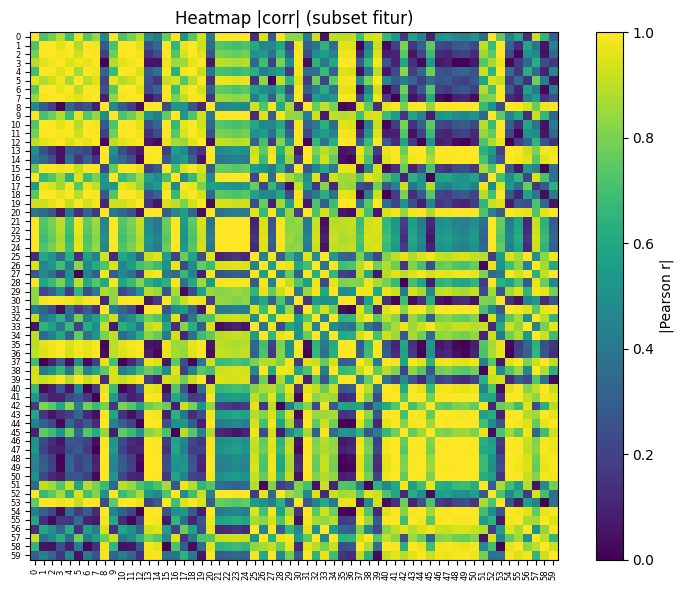

,feat_A,feat_B,corr
0,STAT_flatness_p50,STAT_flux_p25,1.000000
1,SP_dmfcc1_mean,SP_f0_mean,-1.000000
2,SP_mfcc5_mean,MU_chroma9_mean,1.000000
3,STAT_flatness_p25,STAT_flatness_p50,1.000000
4,STAT_flatness_p25,STAT_flux_p25,1.000000
5,SP_mfcc3_std,SP_mfcc8_std,1.000000
6,SP_ddmfcc5_mean,MU_chroma5_mean,0.999999
7,MPEG7_temporal_centroid,MU_contrast1_std,0.999999
8,SP_dmfcc3_mean,MU_contrast3_std,0.999999
9,SP_dmfcc4_mean,MU_chroma1_std,0.999999


In [11]:
#@title Deteksi kolinearitas (pairwise corr) + rekomendasi pruning
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

THRESH = 0.90  # ambang kolinearitas (abs Pearson)
MAX_COLS = 60  # batasi kolom untuk heatmap agar cepat

df = pd.read_csv(OUT_CSV)
y = df["label"].astype(str).values
Xdf = df.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number])

if Xdf.empty or Xdf.shape[1] < 2:
    raise SystemExit("Tidak ada fitur numerik yang cukup untuk analisis korelasi.")

# pilih subset fitur untuk visualisasi (berdasarkan variansi tertinggi agar informatif)
var_rank = Xdf.var().sort_values(ascending=False)
sub_cols = var_rank.index[:min(MAX_COLS, len(var_rank))]
Xsub = Xdf[sub_cols]

# matriks korelasi & heatmap sederhana
corr = Xsub.corr().values
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(corr), vmin=0, vmax=1)
plt.colorbar(label="|Pearson r|")
plt.title("Heatmap |corr| (subset fitur)")
plt.xticks(range(len(sub_cols)), range(len(sub_cols)), rotation=90, fontsize=6)
plt.yticks(range(len(sub_cols)), range(len(sub_cols)), fontsize=6)
plt.tight_layout()
plt.show()

# daftar pasangan dengan |r| >= THRESH (di SELURUH kolom, bukan hanya subset)
pairs = []
cols_all = Xdf.columns.tolist()
C = Xdf.corr().values
for i in range(len(cols_all)):
    for j in range(i+1, len(cols_all)):
        r = C[i, j]
        if np.isfinite(r) and abs(r) >= THRESH:
            pairs.append((cols_all[i], cols_all[j], r))

pairs_sorted = sorted(pairs, key=lambda x: -abs(x[2]))
pd.DataFrame(pairs_sorted, columns=["feat_A","feat_B","corr"]).head(20)

In [12]:
#@title LDA vs PCA (versi clean & aman untuk data kecil)
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score

CSV_IN = OUT_CSV  # ganti ke "features_pruned.csv" kalau pakai hasil pruning
df_ = pd.read_csv(CSV_IN)

# Ambil fitur numerik & label
y_ = df_["label"].astype(str).values
X_ = df_.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number]).values
n, p = X_.shape
n_classes = len(np.unique(y_))

# CV adaptif
def make_cv(y):
    counts = pd.Series(y).value_counts()
    min_cls = counts.min()
    n = len(y)
    if min_cls is not None and min_cls >= 2 and n >= 6:
        # kecilkan n_splits supaya tiap train fold > n_classes
        n_splits = min(3, int(min_cls))
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    else:
        n_splits = max(2, min(3, n))
        return KFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_ = make_cv(y_)

# Pipelines sederhana (kurung & bracket rapi)
pipe_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, svd_solver="full")),
    ("clf", LogisticRegression(max_iter=500, penalty="l2"))
])

pipe_lda = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LDA(solver="svd")),  # LDA butuh train_fold > n_classes
    ("clf", LogisticRegression(max_iter=500, penalty="l2"))
])

def safe_cv(pipe, X, y, cv):
    scores = []
    for train_idx, test_idx in cv.split(X, y):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]

        # Jika di train hanya 1 kelas, atau (pakai LDA dan n_train <= n_classes) → skip fold
        uses_lda = any(name == "lda" for name, _ in pipe.steps)
        if len(np.unique(ytr)) < 2:
            scores.append(np.nan); continue
        if uses_lda and Xtr.shape[0] <= len(np.unique(ytr)):
            scores.append(np.nan); continue

        try:
            pipe.fit(Xtr, ytr)
            yp = pipe.predict(Xte)
            scores.append(f1_score(yte, yp, average="macro"))
        except Exception:
            scores.append(np.nan)

    scores = np.array(scores, dtype=float)
    mean_ = np.nanmean(scores) if np.isfinite(scores).any() else np.nan
    std_  = np.nanstd(scores)  if np.isfinite(scores).any() else np.nan
    return scores, mean_, std_

for name, pipe in [("PCA+LR", pipe_pca), ("LDA+LR", pipe_lda)]:
    folds, mean_, std_ = safe_cv(pipe, X_, y_, cv_)
    print(f"{name} → F1 folds:", np.round(folds, 4),
          "mean=", (None if np.isnan(mean_) else round(mean_, 4)),
          "std=",  (None if np.isnan(std_)  else round(std_, 4)))

PCA+LR → F1 folds: [0. 0. 0.] mean= 0.0 std= 0.0
LDA+LR → F1 folds: [nan nan nan] mean= None std= None


In [13]:
#@title Ablation group-aware (hindari leakage dari file augmented)
import os, re, numpy as np, pandas as pd
from itertools import combinations
from sklearn.model_selection import (
    StratifiedGroupKFold, GroupKFold, StratifiedKFold, KFold, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

CSV_IN = OUT_CSV  # ganti ke "features_pruned.csv" jika pakai hasil pruning
df = pd.read_csv(CSV_IN)

# y, X numerik
y = df["label"].astype(str).values
Xnum = df.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number])
if Xnum.empty:
    raise SystemExit("Tidak ada fitur numerik. Pastikan langkah ekstraksi (#6) sudah sukses.")

# groups dari nama file (gabungkan varian _ts/_ps dengan file aslinya)
def base_stem(p):
    stem = os.path.splitext(os.path.basename(str(p)))[0]
    return re.sub(r'_(ts[0-9.]+|ps[+-]?[0-9.]+)$','', stem, flags=re.IGNORECASE)

groups = df["file"].apply(base_stem).values if "file" in df.columns else np.arange(len(df))

# Definisikan keluarga fitur berdasarkan prefix kolom
all_cols = Xnum.columns.tolist()
FAMILIES = {
    "STAT":  [c for c in all_cols if c.startswith("STAT_")],
    "MPEG7": [c for c in all_cols if c.startswith("MPEG7_")],
    "SP":    [c for c in all_cols if c.startswith("SP_")],
    "MU":    [c for c in all_cols if c.startswith("MU_")],
}

# Pilih CV yang feasible, prioritaskan group-aware
def make_cv(y, groups):
    uniq_g = np.unique(groups)
    min_cls = pd.Series(y).value_counts().min()
    # 1) StratifiedGroupKFold jika tersedia & feasible
    try:
        if len(uniq_g) >= 3 and (min_cls is not None and min_cls >= 2):
            n_splits = min(3, len(uniq_g))
            return StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42), {"groups": groups}, f"StratifiedGroupKFold({n_splits})"
    except Exception:
        pass
    # 2) GroupKFold kalau groups cukup
    if len(uniq_g) >= 3:
        n_splits = min(3, len(uniq_g))
        return GroupKFold(n_splits=n_splits), {"groups": groups}, f"GroupKFold({n_splits})"
    # 3) StratifiedKFold bila tiap kelas ≥2
    if min_cls is not None and min_cls >= 2 and len(y) >= 4:
        n_splits = min(3, int(min_cls))
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42), {}, f"StratifiedKFold({n_splits})"
    # 4) Fallback KFold
    n_splits = min(3, len(y)) if len(y) >= 2 else 2
    return KFold(n_splits=n_splits, shuffle=True, random_state=42), {}, f"KFold({n_splits})"

cv, cv_kwargs, cv_name = make_cv(y, groups)
print("CV:", cv_name)

def eval_cols(cols, name):
    cols = [c for c in cols if c in Xnum.columns]
    if not cols:
        return name, np.nan
    X = Xnum[cols].values
    n, p = X.shape
    min_cls = pd.Series(y).value_counts().min()

    # Adaptasi untuk data kecil
    use_mi  = (n >= 8 and (min_cls is not None and min_cls >= 2) and p > 1)
    use_pca = (n >= 6 and p > 3)
    clf = KNeighborsClassifier(n_neighbors=1) if (n < 8 or (min_cls is not None and min_cls < 2)) else LogisticRegression(max_iter=500)

    steps = [("scaler", StandardScaler())]
    if use_mi:
        steps.append(("kbest", SelectKBest(
            score_func=lambda X_, y_: mutual_info_classif(X_, y_, n_neighbors=1, random_state=42),
            k=min(32, p)
        )))
    if use_pca:
        steps.append(("pca", PCA(n_components=0.95, svd_solver="full")))
    steps.append(("clf", clf))

    pipe = Pipeline(steps)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", error_score=np.nan, **cv_kwargs)
    return name, float(np.nanmean(scores))

# Jalankan ablation: single, pair, dan ALL
rows = []
for fam in FAMILIES:
    rows.append(eval_cols(FAMILIES[fam], fam))

for a, b in combinations(FAMILIES.keys(), 2):
    rows.append(eval_cols(FAMILIES[a] + FAMILIES[b], f"{a}+{b}"))

rows.append(eval_cols(FAMILIES["STAT"] + FAMILIES["MPEG7"] + FAMILIES["SP"] + FAMILIES["MU"], "ALL"))

res_df_ga = pd.DataFrame(rows, columns=["Setting","F1_macro"]).sort_values("F1_macro", ascending=False)
display(res_df_ga)
res_df_ga.to_csv("ablation_groupaware.csv", index=False)
print("Saved: ablation_groupaware.csv")

CV: GroupKFold(3)


,Setting,F1_macro
0,STAT,0.0
1,MPEG7,0.0
2,SP,0.0
3,MU,0.0
4,STAT+MPEG7,0.0
5,STAT+SP,0.0
6,STAT+MU,0.0
7,MPEG7+SP,0.0
8,MPEG7+MU,0.0
9,SP+MU,0.0


Saved: ablation_groupaware.csv


In [14]:
#@title Benchmark model ringan (LR-L2, LR-L1, KNN) — CLEAN & SAFE
import os, re, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (
    KFold, StratifiedKFold, GroupKFold, ShuffleSplit, cross_val_score
)

CSV_IN = OUT_CSV  # ganti ke "features_pruned.csv" jika pakai hasil pruning
dfb = pd.read_csv(CSV_IN)

# X, y
y = dfb["label"].astype(str).values
X = dfb.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number]).values

# groups (anti-leak kalau ada file augmented _ts/_ps)
def base_stem(p):
    stem = os.path.splitext(os.path.basename(str(p)))[0]
    return re.sub(r'_(ts[0-9.]+|ps[+-]?[0-9.]+)$', '', stem, flags=re.IGNORECASE)

groups = dfb["file"].apply(base_stem).values if "file" in dfb.columns else None
has_groups = groups is not None and (len(np.unique(groups)) < len(groups))

def make_cv(y, groups):
    n = len(y)
    min_cls = pd.Series(y).value_counts().min() if n else 0

    # 1) Coba stratified group (kalau tersedia & feasible)
    if has_groups and len(np.unique(groups)) >= 3 and min_cls >= 2:
        try:
            from sklearn.model_selection import StratifiedGroupKFold
            n_splits = min(3, len(np.unique(groups)))
            return StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42), {"groups": groups}, f"StratifiedGroupKFold({n_splits})"
        except Exception:
            pass

    # 2) GroupKFold jika ada groups cukup
    if has_groups and len(np.unique(groups)) >= 3:
        n_splits = min(3, len(np.unique(groups)))
        return GroupKFold(n_splits=n_splits), {"groups": groups}, f"GroupKFold({n_splits})"

    # 3) StratifiedKFold kalau tiap kelas ≥2 & data ≥4
    if min_cls >= 2 and n >= 4:
        n_splits = min(3, int(min_cls))
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42), {}, f"StratifiedKFold({n_splits})"

    # 4) KFold untuk n ≥2; kalau n<2 pakai ShuffleSplit
    if n >= 2:
        n_splits = min(3, n)
        return KFold(n_splits=n_splits, shuffle=True, random_state=42), {}, f"KFold({n_splits})"

    return ShuffleSplit(n_splits=1, test_size=0.5, random_state=42), {}, "ShuffleSplit(1, 0.5)"

cv, cv_kwargs, cv_name = make_cv(y, groups)

models = {
    "LR_L2": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, penalty="l2", class_weight="balanced"))
    ]),
    "LR_L1": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, penalty="l1", solver="liblinear", class_weight="balanced"))
    ]),
    "KNN_1": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=1))
    ]),
}

rows = []
for name, pipe in models.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", error_score=np.nan, **cv_kwargs)
    rows.append([name, scores, float(np.nanmean(scores)), float(np.nanstd(scores))])

res_models = pd.DataFrame(rows, columns=["Model","Folds","Mean_F1","Std_F1"]).sort_values("Mean_F1", ascending=False)
print("CV used:", cv_name)
display(res_models)

# simpan bukti progres
res_models.to_csv("model_benchmark.csv", index=False)
print("Saved: model_benchmark.csv")

CV used: KFold(3)


,Model,Folds,Mean_F1,Std_F1
0,LR_L2,"[0.0, 0.0, 0.0]",0.0,0.0
1,LR_L1,"[0.0, 0.0, 0.0]",0.0,0.0
2,KNN_1,"[0.0, 0.0, 0.0]",0.0,0.0


Saved: model_benchmark.csv


In [15]:
#@title Generate ringkasan laporan → analysis_summary.md (robust)
import os, datetime as dt
import numpy as np
import pandas as pd

# --- helper ---
def safe_exists(path):
    return os.path.exists(path) and os.path.getsize(path) > 0

def pick_ablation():
    # urutan prioritas: variabel in-memory → file CSV
    if 'res_df_ga' in globals() and isinstance(res_df_ga, pd.DataFrame) and not res_df_ga.dropna().empty:
        return res_df_ga.copy(), "group-aware (in-memory)"
    if 'res_df' in globals() and isinstance(res_df, pd.DataFrame) and not res_df.dropna().empty:
        return res_df.copy(), "standard (in-memory)"
    if safe_exists("ablation_groupaware.csv"):
        return pd.read_csv("ablation_groupaware.csv"), "group-aware (csv)"
    if safe_exists("ablation_results.csv"):
        return pd.read_csv("ablation_results.csv"), "standard (csv)"
    return None, None

def pick_conflicts():
    if 'df_conf' in globals() and isinstance(df_conf, pd.DataFrame) and not df_conf.dropna().empty:
        return df_conf.copy()
    if safe_exists("ablation_conflicts.csv"):
        return pd.read_csv("ablation_conflicts.csv")
    return None

# --- dataset stats ---
CSV_IN = globals().get("OUT_CSV", "features.csv")
if not safe_exists(CSV_IN):
    raise SystemExit(f"Tidak menemukan {CSV_IN}. Jalankan ekstraksi fitur dulu.")

df_feat = pd.read_csv(CSV_IN)
y = df_feat["label"].astype(str)
Xnum = df_feat.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number])

n, p = len(df_feat), Xnum.shape[1]
class_counts = y.value_counts().sort_index()

# --- ablation best & synergy ---
ablation_df, abl_source = pick_ablation()
best_txt, single_txt, synergy_txt = "", "", ""
if ablation_df is not None and not ablation_df.dropna().empty:
    ablation_df = ablation_df.dropna(subset=["F1_macro"]).sort_values("F1_macro", ascending=False)
    best_setting = ablation_df.iloc[0]["Setting"]
    best_score = float(ablation_df.iloc[0]["F1_macro"])
    best_txt = f"- Best setting: **{best_setting}** (F1={best_score:.3f})  \n  _Sumber ablation: {abl_source}_"

    fams = ["STAT","MPEG7","SP","MU"]
    singles = ablation_df[ablation_df["Setting"].isin(fams)]
    if not singles.empty:
        srow = singles.iloc[0]
        single_name, single_score = srow["Setting"], float(srow["F1_macro"])
        synergy = best_score - single_score
        single_txt = f"- Best single: **{single_name}** (F1={single_score:.3f})"
        synergy_txt = f"- Synergy gain: **{synergy:+.3f}** (best vs single terbaik)"
else:
    best_txt = "- (Data ablation belum tersedia)"

# --- conflicts ---
conf = pick_conflicts()
conf_txt = "- Tidak ada data konflik."
if conf is not None and not conf.dropna().empty:
    bad = conf[conf.get("conflict", False)==True]
    if not bad.empty:
        w = bad.sort_values("drop_vs_best_single").iloc[0]
        conf_txt = (f"- Konflik terdeteksi: **{w['pair']}** "
                    f"(Δ vs best single={w['drop_vs_best_single']:.3f}). "
                    "Pertimbangkan correlation pruning / PCA lokal / Group-Lasso.")
    else:
        conf_txt = "- Tidak ada pasangan yang lebih buruk dari kedua single-nya."

# --- model benchmark (opsional) ---
bench_txt = "- (Belum ada benchmark model)"
if safe_exists("model_benchmark.csv"):
    bm = pd.read_csv("model_benchmark.csv")
    if not bm.dropna().empty:
        bm = bm.sort_values("Mean_F1", ascending=False)
        bench_txt = f"- Model terbaik: **{bm.iloc[0]['Model']}** (F1={float(bm.iloc[0]['Mean_F1']):.3f})"

# --- compose markdown ---
md = f"""# Ringkasan Ablation & Seleksi Fitur
Tanggal: {dt.datetime.now().date()}

## Statistik Dataset
- Sampel: **{n}**
- Fitur numerik: **{p}**
- Kelas: **{class_counts.shape[0]}**
{class_counts.to_frame('count').to_markdown()}

## Hasil Utama
{best_txt}
{single_txt if single_txt else ""}
{synergy_txt if synergy_txt else ""}

## Konflik / Kolinearitas
{conf_txt}

## Benchmark Model
{bench_txt}

## Rekomendasi Cepat
- Normalisasi fitur (z-norm/CMVN) dan multi-resolusi (frame pendek & panjang).
- Correlation pruning untuk |r| ≥ 0.90; pertimbangkan **Sparse Group Lasso** / **L1**.
- Untuk augmentasi, gunakan **CV group-aware** agar tidak terjadi leakage.
- Bandingkan **PCA vs LDA**; gunakan **LDA** bila klasifikasi & train_fold > jumlah kelas.
"""

with open("analysis_summary.md", "w", encoding="utf-8") as f:
    f.write(md)

print("Saved: analysis_summary.md")
if safe_exists("analysis_summary.md"):
    with open("analysis_summary.md","r",encoding="utf-8") as f:
        print("\n--- PREVIEW (head) ---\n")
        print("".join(f.readlines()[:40]))

Saved: analysis_summary.md

--- PREVIEW (head) ---

# Ringkasan Ablation & Seleksi Fitur
Tanggal: 2025-10-03

## Statistik Dataset
- Sampel: **3**
- Fitur numerik: **134**
- Kelas: **3**  
| label   |   count |
|:--------|--------:|
| env     |       1 |
| music   |       1 |
| speech  |       1 |

## Hasil Utama
- Best setting: **STAT** (F1=0.000)  
  _Sumber ablation: group-aware (in-memory)_
- Best single: **STAT** (F1=0.000)
- Synergy gain: **+0.000** (best vs single terbaik)

## Konflik / Kolinearitas
- Tidak ada pasangan yang lebih buruk dari kedua single-nya.

## Benchmark Model
- Model terbaik: **LR_L2** (F1=0.000)

## Rekomendasi Cepat
- Normalisasi fitur (z-norm/CMVN) dan multi-resolusi (frame pendek & panjang).
- Correlation pruning untuk |r| ≥ 0.90; pertimbangkan **Sparse Group Lasso** / **L1**.
- Untuk augmentasi, gunakan **CV group-aware** agar tidak terjadi leakage.
- Bandingkan **PCA vs LDA**; gunakan **LDA** bila klasifikasi & train_fold > jumlah kelas.



In [16]:
#@title 14) Zip artefak (CSV + ringkasan) → artifacts.zip  [+ opsi simpan ke Drive]
import os, shutil
from zipfile import ZipFile

# daftar file kandidat yang biasanya dihasilkan
CANDIDATES = [
    "features.csv",
    "features_pruned.csv",
    "ablation_results.csv",
    "ablation_conflicts.csv",
    "ablation_groupaware.csv",
    "model_benchmark.csv",
    "analysis_summary.md",
]

# tambahkan file lain kalau ada (mis. tabel ablation custom)
EXTRA = []  # contoh: ["res_df.csv"]

FILES = [f for f in (CANDIDATES + EXTRA) if os.path.exists(f) and os.path.getsize(f) > 0]

if not FILES:
    print("Belum ada artefak untuk di-zip. Jalankan dulu langkah 6–13.")
else:
    # hapus zip lama kalau ada
    if os.path.exists("artifacts.zip"):
        os.remove("artifacts.zip")

    with ZipFile("artifacts.zip", "w") as zf:
        for f in FILES:
            zf.write(f)
            print("include:", f)
    print("\nSaved: artifacts.zip (cek di file browser Colab)")

# ==== Opsi: salin ke Google Drive ====
SAVE_TO_DRIVE = False  #@param {type:"boolean"}
DRIVE_DIR = "/content/drive/MyDrive/MultimodalAudioArtifacts"  #@param {type:"string"}

if SAVE_TO_DRIVE and os.path.exists("artifacts.zip"):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    os.makedirs(DRIVE_DIR, exist_ok=True)
    shutil.copy("artifacts.zip", os.path.join(DRIVE_DIR, "artifacts.zip"))
    print("Copied to:", os.path.join(DRIVE_DIR, "artifacts.zip"))

# ==== (Opsional) Cetak snippet Markdown untuk LINKS.md ====
if os.path.exists("artifacts.zip"):
    print("\n--- Markdown (copy ke LINKS.md / log progres) ---\n")
    print("- Artefak eksperimen: `artifacts.zip` (berisi CSV ablation/benchmark & `analysis_summary.md`)")

include: features.csv
include: ablation_results.csv
include: ablation_conflicts.csv
include: ablation_groupaware.csv
include: model_benchmark.csv
include: analysis_summary.md

Saved: artifacts.zip (cek di file browser Colab)

--- Markdown (copy ke LINKS.md / log progres) ---

- Artefak eksperimen: `artifacts.zip` (berisi CSV ablation/benchmark & `analysis_summary.md`)


In [17]:
#@title Per-kelas metrics + confusion matrix (safe utk data kecil)
import os, re, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

CSV_IN = OUT_CSV  # atau "features_pruned.csv"
dfm = pd.read_csv(CSV_IN)
y = dfm["label"].astype(str).values
X = dfm.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number])

# groups anti-leak (kalau ada augment _ts/_ps)
def base_stem(p):
    stem = os.path.splitext(os.path.basename(str(p)))[0]
    return re.sub(r'_(ts[0-9.]+|ps[+-]?[0-9.]+)$','', stem, flags=re.IGNORECASE)
groups = dfm["file"].apply(base_stem).values if "file" in dfm.columns else None

# CV aman (prioritas group-aware)
cv = None; cv_kwargs = {}
uniq_groups = np.unique(groups) if groups is not None else []
if groups is not None and len(uniq_groups) >= 3:
    cv = GroupKFold(n_splits=min(3, len(uniq_groups)))
    cv_kwargs = {"groups": groups}
else:
    min_cls = pd.Series(y).value_counts().min()
    if min_cls is not None and min_cls >= 2 and len(y) >= 4:
        cv = StratifiedKFold(n_splits=min(3, int(min_cls)), shuffle=True, random_state=42)
    else:
        cv = KFold(n_splits=min(3, len(y)) if len(y) >= 2 else 2, shuffle=True, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])

# Prediksi CV (bisa NaN kalau fold “aneh”, jadi kita handle try/except)
try:
    y_pred = cross_val_predict(pipe, X.values, y, cv=cv, method="predict", **cv_kwargs)
    print(classification_report(y, y_pred, digits=4))
    labels = np.unique(y)
    cm = confusion_matrix(y, y_pred, labels=labels)
    print("Labels:", labels.tolist())
    print("Confusion matrix:\n", cm)
except Exception as e:
    print("Gagal membuat prediksi CV:", e)

              precision    recall  f1-score   support

         env     0.0000    0.0000    0.0000       1.0
       music     0.0000    0.0000    0.0000       1.0
      speech     0.0000    0.0000    0.0000       1.0

    accuracy                         0.0000       3.0
   macro avg     0.0000    0.0000    0.0000       3.0
weighted avg     0.0000    0.0000    0.0000       3.0

Labels: ['env', 'music', 'speech']
Confusion matrix:
 [[0 1 0]
 [0 0 1]
 [0 1 0]]


In [18]:
#@title Train full-data, simpan model, dan prediksi file baru
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 16a) latih di seluruh data fitur
df_full = pd.read_csv(CSV_IN)
y_full = df_full["label"].astype(str).values
X_full = df_full.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number])

pipe_full = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])
pipe_full.fit(X_full.values, y_full)
joblib.dump({"model": pipe_full, "columns": X_full.columns.tolist()}, "audio_model.joblib")
print("Saved: audio_model.joblib")

# 16b) helper: prediksi dari 1 file audio (pakai fungsi ekstraksi yang sudah ada di notebook)
def predict_audio_file(wav_path, sr_target=22050):
    # fungsi extract_one() sudah didefinisikan di langkah ekstraksi (#6); kita panggil ulang
    row = extract_one(wav_path, sr_target=sr_target)  # -> dict
    meta_cols = ["file","label"]  # mungkin tidak ada label untuk file baru
    feat = pd.DataFrame([row])
    # sinkronkan kolom dengan training
    saved = joblib.load("audio_model.joblib")
    cols = saved["columns"]
    for c in cols:
        if c not in feat.columns:
            feat[c] = 0.0
    feat = feat[cols]  # urutan kolom sama
    pred = saved["model"].predict(feat.values)[0]
    return pred

# contoh pakai:
# print(predict_audio_file("/content/data/speech/something.wav"))

Saved: audio_model.joblib


In [19]:
#@title Mini hyperparameter sweep (ringkas)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

dfh = pd.read_csv(CSV_IN)
y = dfh["label"].astype(str).values
X = dfh.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number]).values

min_cls = pd.Series(y).value_counts().min()
cv = StratifiedKFold(n_splits=min(3, int(min_cls)), shuffle=True, random_state=42) if (min_cls is not None and min_cls>=2 and len(y)>=4) \
     else KFold(n_splits=min(3, len(y)) if len(y)>=2 else 2, shuffle=True, random_state=42)

pipe = Pipeline([("scaler", StandardScaler()),
                 ("clf", LogisticRegression(max_iter=800, class_weight="balanced"))])
param_grid = {
    "clf__penalty": ["l2", "l1"],
    "clf__solver": ["lbfgs", "liblinear"],  # liblinear mendukung l1/l2; lbfgs hanya l2
    "clf__C": [0.1, 1.0, 3.0]
}
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1_macro", error_score=np.nan)
gs.fit(X, y)
print("Best params:", gs.best_params_, "Best F1:", round(gs.best_score_, 4))

Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'} Best F1: 0.0


In [20]:
#@title Repro config & versions
import sys, platform, random, numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED)

import sklearn, librosa
print("Python:", sys.version.split()[0], "| OS:", platform.platform())
print("sklearn:", sklearn.__version__, "| librosa:", librosa.__version__)

Python: 3.12.11 | OS: Linux-6.6.97+-x86_64-with-glibc2.35
sklearn: 1.6.1 | librosa: 0.10.2.post1


In [21]:
#@title Audit cepat dataset
import pandas as pd, numpy as np, librosa, os, re

meta = scan_data_dir(DATA_DIR)
dur = []
for p in meta["file"]:
    try:
        d = librosa.get_duration(filename=p)
    except Exception:
        d = np.nan
    dur.append(d)
meta["duration_s"] = dur

display(meta.groupby("label")["file"].count().rename("count"))
display(meta.groupby("label")["duration_s"].agg(["count","mean","min","max"]).round(2))

,count
label,
env,1
music,1
speech,1


,count,mean,min,max
label,,,,
env,1,2.50,2.50,2.50
music,1,5.33,5.33,5.33
speech,1,2.50,2.50,2.50


In [22]:
#@title Cek grup (anti-leak) setelah augmentasi
import re, pandas as pd
def base_stem(p):
    stem = os.path.splitext(os.path.basename(str(p)))[0]
    return re.sub(r'_(ts[0-9.]+|ps[+-]?[0-9.]+)$','', stem, flags=re.IGNORECASE)

meta["group"] = meta["file"].apply(base_stem)
dup = meta["group"].value_counts()
print("Total files:", len(meta), "| Unique groups:", meta["group"].nunique())
print("Groups dengan >1 varian (indikasi augmented):", int((dup>1).sum()))

Total files: 3 | Unique groups: 3
Groups dengan >1 varian (indikasi augmented): 0


In [23]:
#@title Simpan indeks CV terakhir (kalau variabel cv ada)
import json, numpy as np
try:
    X_preview = df.drop(columns=["label","file"], errors="ignore").select_dtypes(include=[np.number]).values
    y_preview = df["label"].astype(str).values
    folds = []
    # Gunakan groups kalau tersedia dari sesi ablation/benchmark
    g = None
    if "groups" in globals():
        g = groups
    splitter = cv  # gunakan splitter terakhir yang kamu pakai (mis. dari #11 atau #12)
    for i, (tr, te) in enumerate(splitter.split(X_preview, y_preview, **({"groups": g} if g is not None and "groups" in splitter.split.__code__.co_varnames else {}))):
        folds.append({"fold": i, "train_idx": np.array(tr).tolist(), "test_idx": np.array(te).tolist()})
    with open("cv_splits.json", "w") as f:
        json.dump(folds, f)
    print("Saved: cv_splits.json")
except Exception as e:
    print("Lewati simpan CV splits (tidak menemukan objek cv/df).", e)

Saved: cv_splits.json


In [24]:
#@title Dengar 1 contoh per kelas (untuk demo)
from IPython.display import Audio, display
for lbl, grp in meta.groupby("label"):
    path = grp["file"].iloc[0]
    print("Label:", lbl, "→", os.path.basename(path))
    display(Audio(path))

Label: env → noise_env.wav


Label: music → trumpet_demo.wav


Label: speech → speech_sine.wav


In [25]:
#@title Ekspor notebook ke HTML (untuk dikumpulkan)
!pip -q install nbconvert==7.* jinja2 pygments
!jupyter nbconvert --to html "Kelompok_4_KAV (2).ipynb" -o "notebook_report.html"

[NbConvertApp] WARNING | Unrecognized alias: 'o', it will have no effect.
[NbConvertApp] WARNING | pattern 'Kelompok_4_KAV (2).ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions inst